In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, homogeneity_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
import plotly
import plotly.graph_objs as go
import chart_studio.plotly as py

import seaborn as sns
import shap

from scipy.spatial.distance import euclidean, cosine
import umap
import random


In [4]:
df = pd.read_csv('../datasets/supremacy_Data.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,text,label,processed
0,0,0,as of march th the booklet had been...,0.0,march booklet been downloaded over times counting
1,1,1,in order to help increase the booklets downloa...,0.0,order help increase booklets downloads would g...
2,2,2,simply copy and paste the following text int...,0.0,simply copy paste following text into your you...
3,3,3,click below for a free download of a colorfull...,1.0,click below free download colorfully illustrat...
4,4,4,click on the download mb green ...,0.0,click download green banner link


In [6]:
df['label'].value_counts()

0.0    9291
1.0    1172
Name: label, dtype: int64

In [19]:
df_nonhate = df.loc[df['label']==0]
df_nonhate = df_nonhate.sample(1172)

In [20]:
df_hate = df.loc[df['label']==1]
df = df_hate.append(df_nonhate)

In [22]:
df.shape, df['label'].value_counts()

((2315, 5), 0.0    1172
 1.0    1143
 Name: label, dtype: int64)

In [23]:
df.dropna(inplace=True)

In [24]:
x = df['processed'].values
y = df['label'].values


## TF-IDF
We are going to use TF*IDF (Term frequency- Inverse document frequency) vectorizer to convert our text into numbers.
TF = Frequency of term
IDF = No of docs/ No of docs with the term

In [25]:
tfid = TfidfVectorizer(max_features=5000)
x = tfid.fit_transform(x).toarray()
x.shape

(2315, 5000)

In [26]:
tfid.get_feature_names();

#### Splitting data
We split data as follows:
- train = 20%
- test = 20%
- unlabelled pool = 60% (this is the data which we want the domain expert to label)

In [27]:
indices =  np.random.randint(low=0, high=x.shape[0], size=x.shape[0])
train_indices = indices[0:round(0.6*x.shape[0])]
test_indices = indices[round(0.6*x.shape[0]): ]
pool_indices = indices[round(0.7*x.shape[0]):]
df_train = df.iloc[train_indices]['processed'].values
df_test = df.iloc[test_indices]['processed'].values
df_pool = df.iloc[pool_indices]['text'].values
x_train = x[train_indices]
y_train = y[train_indices]
x_test = x[test_indices]
y_test = y[test_indices]
x_pool = x[pool_indices]
y_pool = y[pool_indices]

#### Model fitting
We are going to use Logistic regression with L1 regularization. Reasons for L1:
- We are going to apply shapely values - L1 => sparse model => better for interpretability
- We prefer a sparse model because not all features are important (feature selection)
- It results in better accuracy in this case

In [49]:
PENALTY = 'l2'
C = 1000



In [50]:
model = SVC( max_iter=1000, C=C, kernel='linear')
model.fit(x_train, y_train)
model.score(x_train,y_train)

C:\Users\s164255\anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning:

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



0.9949604031677466

We measure the f1_score and plot confusion matrix. Recall:
- f1 score = 2PR/ (P+R)
- P = actual pos/ predicted pos
- R = predicted pos/ total actual pos

In [51]:
predictions = model.predict(x_test)
f1_score(predictions,
         y_test)

0.7172717271727173

In [52]:
accuracy_score(y_test, predictions)

0.7224622030237581

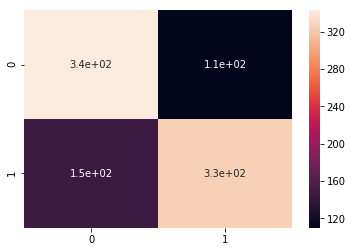

In [53]:
sns.heatmap(confusion_matrix(y_test, predictions),annot=True)

In [54]:
np.array(np.unique(y_test, return_counts=True)).T

array([[  0., 453.],
       [  1., 473.]])

#### SHAP Linear explainer

Refer https://christophm.github.io/interpretable-ml-book/shap.html

The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition. Shapley values tell us how to fairly distribute the “payout” (= the prediction) among the features

We call the SHAP explainer for linear models
shapely values produced have same dimensions as data passed

In [55]:
explainer = shap.LinearExplainer(model, x_train,feature_dependence="independent")
shap_values_train = explainer.shap_values(x_train)
shap_values_pool = explainer.shap_values(x_test)

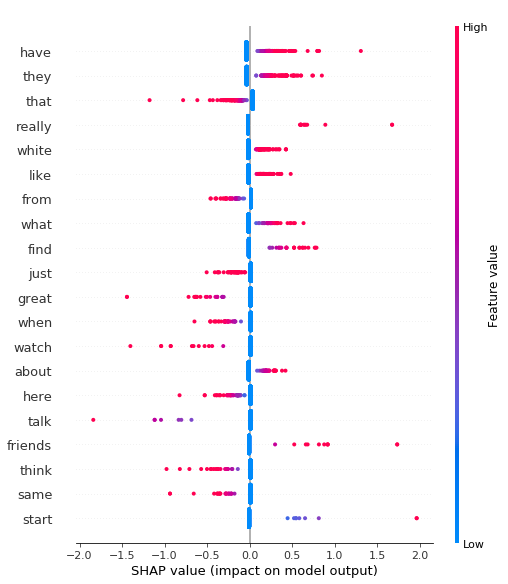

In [56]:
shap.summary_plot(shap_values_pool, x_test, feature_names=tfid.get_feature_names())

In [40]:
shap_values_pool.shape

(926, 5000)

#### Clustering data
We are going to cluster the training data 
    - using shapely values (shapely space)
SHAP clustering works by clustering on Shapley values of each instance. 
This means that you cluster instances by explanation similarity

In [41]:
tsne = TSNE(n_components=2, perplexity=20)
principals = tsne.fit_transform(
    shap_values_pool)

In [42]:
n_clusters = 20

In [43]:
kmeans = KMeans(n_clusters= n_clusters, n_jobs=-1, max_iter=600)
kmeans.fit(shap_values_pool)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=20, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [44]:
print("Homogenity score", homogeneity_score(y_test, kmeans.labels_))

Homogenity score 0.03936448813552272


We use cosine distance instead of euclidean distance to measure the similarity between the documents.
As the size of the document increases, the number of common words (euclidean) tend to increase 
even if the documents talk about different topics. The cosine similarity helps overcome this fundamental flaw 
and finds the similarity irrespective of size.

https://www.machinelearningplus.com/nlp/cosine-similarity/

In [ ]:
# Find similarity of each point in cluster to its centroid
similarity_to_center = []
for i, instance in enumerate(shap_values_pool):
    cluster_label = kmeans.labels_[i] # cluster of this instance
    centroid = kmeans.cluster_centers_[cluster_label] # cluster center of the cluster of that instance
    similarity = 1-cosine(instance, centroid) # 1- cosine distance gives similarity
    similarity_to_center.append(similarity)

In [ ]:
centroid_match = [None]*n_clusters
centroid_indices =[None]*n_clusters
for i, instance in enumerate(shap_values_pool):
    cluster_label = kmeans.labels_[i]     
    if centroid_match[cluster_label] is None or similarity_to_center[i] > centroid_match[cluster_label]:
        centroid_indices[cluster_label] = i
        centroid_match[cluster_label] = similarity_to_center[i]
        

In [ ]:
data = []
collect = dict()
color = ['hsl(' + str(h) + ',80%' + ',50%)' for h in np.linspace(0, 255, n_clusters)]
# color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
#              for i in range(n_clusters)]
for cluster_id in np.unique(kmeans.labels_):
    cluster_indices = np.where(kmeans.labels_ == cluster_id)    
    cluster_text = df_test[cluster_indices]
    center_index = centroid_indices[cluster_id]

    cp = principals[cluster_indices]
    data.append(go.Scatter(x = cp[:,0],
                   y = cp[:,1],
                   mode='markers',                    
                hovertext=cluster_text,
                           text = cluster_text,
                           textposition = 'middle right',
                            marker=dict(color=color[cluster_id],
                                                   size=10),
                           name = 'cluster '+ str(cluster_id)
                          ))
    data.append(go.Scatter(x = [principals[center_index, 0]],
                   y = [principals[center_index, 1]],
                           visible=True,
                   mode='markers',  
                           marker=dict(color=color[cluster_id],
                                                   size=15,
                                                   line=dict(color='black', width=5)),
                           name = 'centroid cluster '+ str(cluster_id)
                          ))
    collect[cluster_id] = df_test[cluster_indices]
    
fig = go.Figure(data=data)
fig.show()
#plotly.offline.plot(fig)

In [ ]:
#url=py.plot(fig, filename='bird', sharing='public')

In [ ]:
centroid_indices

In [ ]:
# for item in collect[11]:
#     print(item)

#### Propagate label of centroid to entire cluster

In [ ]:
y_pool_new = np.zeros(shape=y_pool.shape)
for cluster_id in np.unique(kmeans.labels_):
    cluster_indices = np.where(kmeans.labels_ == cluster_id)    
    center_index = centroid_indices[cluster_id]
    center_label = y_pool[center_index]
    print(center_label)
    y_pool_new[cluster_indices] = center_label
    print(y_pool_new[cluster_indices])
y_new = np.zeros(shape=y.shape)
y_new[pool_indices] = y_pool_new

In [ ]:
compare = (y_pool_new == y_pool)
np.where(compare==True)[0].shape

In [ ]:
compare = (y_pool_new != y_pool)
np.where(compare==True)[0].shape

In [ ]:
train_indices_new = np.append(pool_indices, centroid_indices)


In [ ]:
model1 = LogisticRegression(penalty=PENALTY, C=C, max_iter=max_iter)
x_train_new = x[train_indices_new]
y_train_new = y[train_indices_new]
model1.fit(x_train_new, y_train_new)

In [ ]:
model1.score(x_train_new, y_train_new), model1.score(x_test, y_test)

In [ ]:
predictions1 = model1.predict(x_test)
f1_score(y_test, predictions1)

In [ ]:
accuracy_score(y_test, predictions1)

#### Add entire x_pool back to training instead of just centroids

In [ ]:
train_indices_full = np.append(train_indices, pool_indices)

In [ ]:
model2 = LogisticRegression(penalty=PENALTY, C=C, max_iter=max_iter)
x_train_full = x[train_indices_full]
y_train_full = y[train_indices_full]
model2.fit(x_train_full, y_train_full)
model2.score(x_train_full, y_train_full), model2.score(x_test, y_test)

In [ ]:
predictions2 = model2.predict(x_test)
f1_score(y_test, predictions2)

In [ ]:
accuracy_score(y_test, predictions2)

#### Compare

In [ ]:
print("Model with 20% train ", f1_score(y_test, predictions))
print("Model with 20% train + propagate center ", f1_score(y_test, predictions1))
print("Model with 20% train + 60% pool ", f1_score(y_test, predictions2))

In [ ]:
print("Model with 20% train ", accuracy_score(y_test, predictions))
print("Model with 20% train + propagate center ", accuracy_score(y_test, predictions1))
print("Model with 20% train + 60% pool ", accuracy_score(y_test, predictions2))